## Example 05 - Defining a basic simulation on a real graph

### Imports
Import the required libraries

In [1]:
import opentnsim
print('This notebook has been tested with OpenTNSim version {}'.format(opentnsim.__version__))

This notebook has been tested with OpenTNSim version 1.0.0


In [2]:
# package(s) related to time, space and id
import datetime, time
import platform
import random
import os
import pathlib

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSIM
import opentnsim.core as core

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

# Graph location
location_graph = (os.path.relpath(pathlib.Path.cwd(), "notebooks"))
name_graph = "notebooks/Shape-Files/Rotterdam-Antwerpen-corridor/edges_2.shp"


### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

C:\Users\tenzi\AppData\Local\Temp/ipykernel_17816/3540487524.py:2: DeprecationWarning:

read_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.



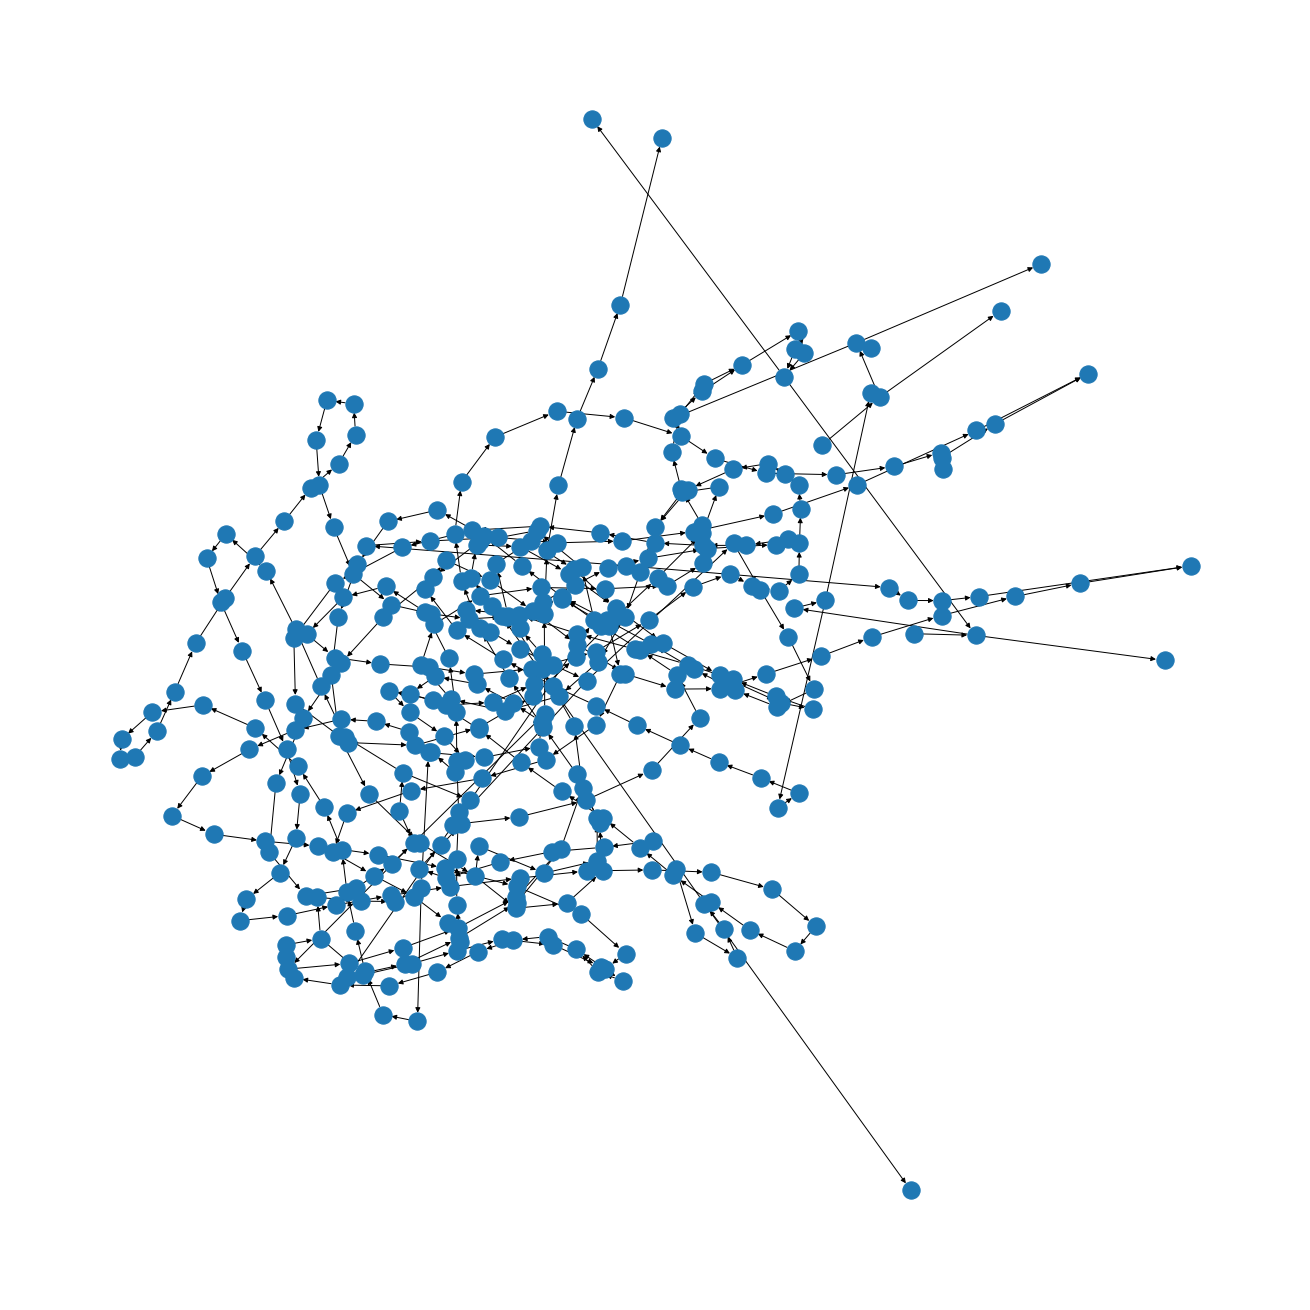

In [3]:
# Read the shape-file
FG = nx.read_shp(os.path.join(location_graph, name_graph), 
                 simplify=True)

# Draw the shape-file to get a first impression
plt.figure(figsize=(18,18))
nx.draw(FG)

# Show the drawing
plt.show()

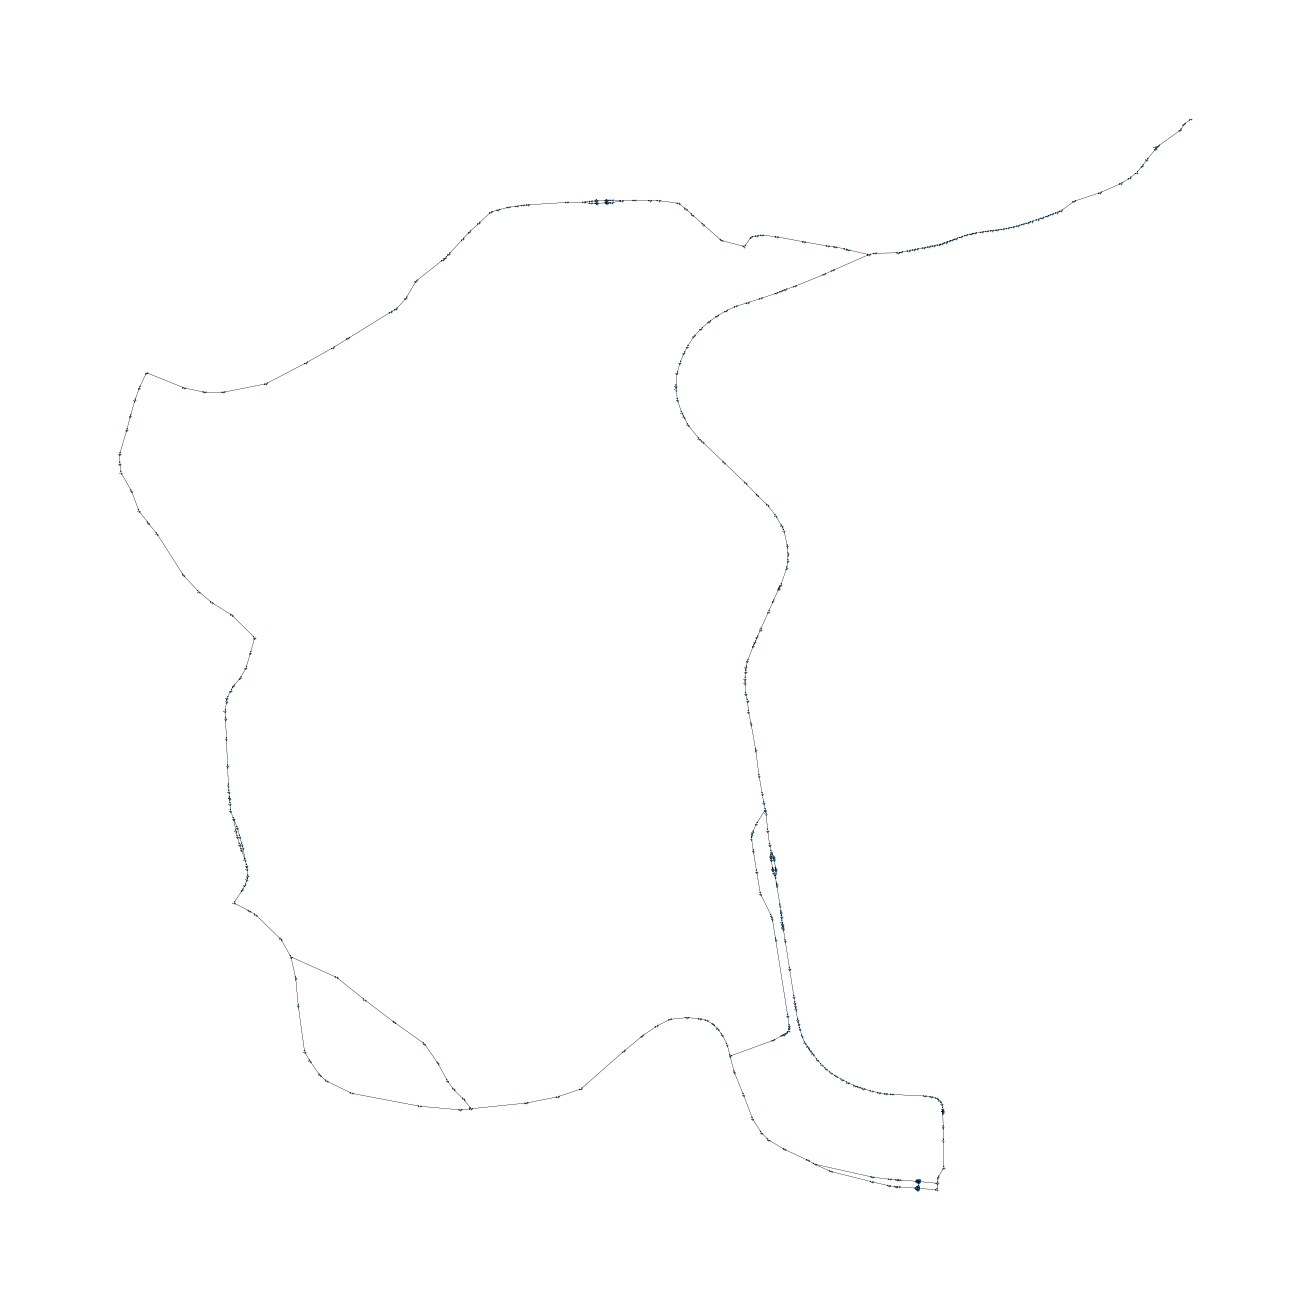

In [4]:
# calculate distance between two points
def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps='WGS84')
    
    distance = wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                         shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2]
    
    return distance

H_G = nx.Graph()

lat_lon_to_index = {}
edge_id_counter = 0

for i, node in enumerate(FG.nodes(data = True)):
    H_G.add_node(i, pos = node[0], 
                    name = "Node {}".format(i),
                    geometry = shapely.geometry.Point(node[0][0], node[0][1]))
    lat_lon_to_index[node[0]] = i

    
for edge in FG.edges(data=True): 
    H_G.add_edge(lat_lon_to_index[edge[0]], 
                 lat_lon_to_index[edge[1]],
                 dis= calculate_distance(nx.get_node_attributes(H_G, 'geometry')[lat_lon_to_index[edge[1]]], 
                                         nx.get_node_attributes(H_G, 'geometry')[lat_lon_to_index[edge[0]]]))

FG = H_G.to_directed()
plt.figure(figsize=(18,18))
nx.draw(FG, nx.get_node_attributes(FG, 'pos'), with_labels=True, node_size=0.5, font_size = 2, width = 0.2, arrowsize = 3)
plt.show()

### Create vessels
Vessel without graph, but with shortest path.

In [5]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (core.Identifiable, core.ContainerDependentMovable, 
                          core.HasResource, core.Routeable), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

# create the transport processing resource
vessel = TransportResource(**data_vessel)

### Define paths

In [6]:
# First simulation is from random node 1 to random node 2
random_1 = random.choice(list(FG))
random_2 = random.choice(list(FG))

path_1 = nx.dijkstra_path(FG, random_1, random_2)
print(path_1)

[125, 126, 26, 27, 28, 135, 310, 190, 191, 192, 121, 122, 123, 330, 331, 127, 128, 129, 318, 60, 61, 62, 0, 1, 2, 218, 217, 216, 156, 155, 154, 394, 184, 182, 183, 258, 259, 283, 185, 186, 91, 92, 93, 142, 384, 385, 187, 188, 151, 147, 148, 149, 360, 361, 189, 21, 22, 3, 4, 5, 375, 6, 7, 8, 211, 212, 175, 176, 177, 355, 291, 292, 293, 297, 298, 299, 407, 408, 202, 203, 204, 362, 213, 214, 215, 326, 327, 406, 199, 200, 201, 381, 56, 57, 58, 339, 76, 77, 78, 392, 391, 390, 312, 311, 262, 261, 260, 368, 319, 198, 197, 196, 399, 398, 397, 334, 333, 323, 322, 321, 377]


In [7]:
# First simulation is from random node 1 to random node 2
random_1 = random.choice(list(FG))
random_2 = random.choice(list(FG))

path_2 = nx.dijkstra_path(FG, random_1, random_2)
print(path_2)

[338, 46, 45, 44, 347, 346, 348, 382, 379, 178, 179, 139, 140, 141, 250, 249, 160, 138, 137, 136, 367, 39, 38, 40, 337, 336, 335, 400, 302, 301, 300, 405, 78, 392, 391, 390, 312, 311, 262, 261, 260, 368, 319, 198, 197, 196, 399, 398, 397, 334, 333, 323, 322, 321, 377, 376, 371, 370, 369, 11, 10, 9, 358, 357, 374, 268, 267, 266, 386, 276, 275]


In [8]:
paths = [path_1, path_2]

### Run simulation

In [9]:
def start(env, vessel):
    while True:
        vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        
        if vessel.geometry == nx.get_node_attributes(FG, "geometry")[vessel.route[-1]]:
            break

In [10]:
for path in enumerate(paths):
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())
    
    # Add graph to environment
    env.FG = FG
    
    # Add environment and path to the vessel
    vessel.env = env
    vessel.route = path[1]

    # Start the simulation
    env.process(start(env, vessel))
    env.run()

    print("Simulation of path {} took {} seconds".format(path[0] + 1, int(env.now)))

Origin POINT (0 0)
Destination POINT (4.2448005 51.3891096)
Simulation of path 1 took 1653702702 seconds
Origin POINT (4.3208246 51.652197)
Destination POINT (4.1138364 51.6581441)
Simulation of path 2 took 1647990045 seconds


### Testing
With v = 1 the distance of a path should be equal to the simulation time.

If simulation time == distance of path, test succeeds.

In [11]:
for geo in vessel.log["Geometry"]:
    print(geo.x, geo.y)

0.0 0.0
4.2448005 51.3891096
4.2448005 51.3891096
4.243556 51.390529
4.243556 51.390529
4.2423114 51.3926981
4.2423114 51.3926981
4.2414102 51.3951081
4.2414102 51.3951081
4.2409164 51.3966421
4.2409164 51.3966421
4.2405519 51.3978124
4.2405519 51.3978124
4.2398223 51.4013466
4.2398223 51.4013466
4.2395723 51.4024845
4.2395723 51.4024845
4.2393932 51.4033546
4.2393932 51.4033546
4.2389773 51.4054227
4.2389773 51.4054227
4.2371906 51.4143703
4.2371906 51.4143703
4.2354036 51.4233059
4.2354036 51.4233059
4.2346296 51.4271755
4.2346296 51.4271755
4.2345269 51.4276401
4.2345269 51.4276401
4.2344694 51.4278823
4.2344694 51.4278823
4.2343266 51.4285123
4.2343266 51.4285123
4.2342282 51.4289006
4.2342282 51.4289006
4.2340717 51.4296372
4.2340717 51.4296372
4.2338571 51.4311088
4.2338571 51.4311088
4.2337025 51.4322651
4.2337025 51.4322651
4.2336425 51.4327141
4.2336425 51.4327141
4.2332563 51.4348277
4.2332563 51.4348277
4.2319184 51.441247
4.2319184 51.441247
4.2318401 51.4416226
4.2318401 5

In [12]:
vessel.log["Timestamp"]

[datetime.datetime(2022, 3, 22, 14, 47, 45),
 datetime.datetime(2022, 5, 27, 17, 44, 40, 479438),
 datetime.datetime(2022, 5, 27, 17, 44, 40, 479438),
 datetime.datetime(2022, 5, 27, 17, 47, 40, 595543),
 datetime.datetime(2022, 5, 27, 17, 47, 40, 595543),
 datetime.datetime(2022, 5, 27, 17, 51, 56, 998631),
 datetime.datetime(2022, 5, 27, 17, 51, 56, 998631),
 datetime.datetime(2022, 5, 27, 17, 56, 32, 364285),
 datetime.datetime(2022, 5, 27, 17, 56, 32, 364285),
 datetime.datetime(2022, 5, 27, 17, 59, 26, 456759),
 datetime.datetime(2022, 5, 27, 17, 59, 26, 456759),
 datetime.datetime(2022, 5, 27, 18, 1, 39, 107762),
 datetime.datetime(2022, 5, 27, 18, 1, 39, 107762),
 datetime.datetime(2022, 5, 27, 18, 8, 15, 573231),
 datetime.datetime(2022, 5, 27, 18, 8, 15, 573231),
 datetime.datetime(2022, 5, 27, 18, 10, 23, 361189),
 datetime.datetime(2022, 5, 27, 18, 10, 23, 361189),
 datetime.datetime(2022, 5, 27, 18, 12, 0, 964021),
 datetime.datetime(2022, 5, 27, 18, 12, 0, 964021),
 dateti

In [13]:
wgs84 = pyproj.Geod(ellps='WGS84')
distance_path_1 = 0
distance_path_2 = 0

for node in enumerate(path_1):
    orig = nx.get_node_attributes(FG, "geometry")[path_1[node[0]]]
    dest = nx.get_node_attributes(FG, "geometry")[path_1[node[0] + 1]]

    distance_path_1 += int(wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                                     shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2])
    
    if node[0] + 2 == len(path_1):
                break

for node in enumerate(path_2):
    orig = nx.get_node_attributes(FG, "geometry")[path_2[node[0]]]
    dest = nx.get_node_attributes(FG, "geometry")[path_2[node[0] + 1]]

    distance_path_2 += int(wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                                     shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2])
    
    if node[0] + 2 == len(path_2):
                break

In [14]:
distance_path_1, distance_path_2

(36363, 18800)